# Sequence-Structure Coverage

In [1]:
from pyspark.sql import Row,SparkSession
from pyspark import SparkContext
from mmtfPyspark.structureViewer import view_binding_site
from mmtfPyspark.ml import pythonRDDToDataset
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.filters import PolymerComposition
from mmtfPyspark.mappers import StructureToPolymerChains
from pyspark.sql.functions import concat_ws
from mmtfPyspark.datasets import g2sDataset, pdbjMineDataset, myVariantDataset
import pandas as pd
import matplotlib
import py3Dmol
from mmtfPyspark.structureViewer import view_structure

#### Configure Spark

In [2]:
spark = SparkSession.builder.master("local[4]").appName("sequence_structure_coverage").getOrCreate()
sc = spark.sparkContext

In [3]:
path = "../mmtf_full_sample"
pdb = mmtfReader.read_sequence_file(path, sc, fraction=0.1)
#pdb.count()



## Load in PFAM data

In [4]:
pfam_data = pd.read_csv("pdb_pfamA_reg.txt",sep='\t',header=(0), low_memory=False)
pfam_data.head(10)

,auto_pdb_reg,auto_uniprot_reg_full,pdb_id,pfamA_acc,pfamseq_acc,chain,pdb_res_start,pdb_start_icode,pdb_res_end,pdb_end_icode,seq_start,seq_end,hex_color
0,1297621,216075477,3H3M,PF05400,A0A0H3LVQ9,B,34,NaN,106,NaN,34,106,2dcf00
1,1297622,216075477,3H3M,PF05400,A0A0H3LVQ9,A,34,NaN,106,NaN,34,106,2dcf00
2,1297623,216077339,3NKZ,PF05400,A1JSR8,C,21,NaN,92,NaN,21,92,2dcf00
3,1297624,216077339,3NKZ,PF05400,A1JSR8,B,21,NaN,94,NaN,21,94,2dcf00
4,1297625,216077339,3NKZ,PF05400,A1JSR8,D,21,NaN,93,NaN,21,93,2dcf00
5,1297626,216077339,3NKZ,PF05400,A1JSR8,A,21,NaN,94,NaN,21,94,2dcf00
6,1297627,216086231,3A7M,PF05400,P0A1N2,A,21,NaN,106,NaN,21,106,2dcf00
7,1297628,216086231,5KS6,PF05400,P0A1N2,A,21,NaN,106,NaN,21,106,2dcf00
8,1297629,216086231,5KRW,PF05400,P0A1N2,A,21,NaN,95,NaN,21,95,2dcf00
9,1297630,216086231,3A7M,PF05400,P0A1N2,B,21,NaN,106,NaN,21,106,2dcf00


### Trim dataset to only keep information we need

In [5]:
d = {'chainId': pfam_data['pdb_id']+'.'+pfam_data['chain'], 'pfam':pfam_data['pfamA_acc'], 'pdb_res_start': pfam_data['pdb_res_start'], 'pdb_res_end':pfam_data['pdb_res_end'], 'range':pfam_data['pdb_res_end']-pfam_data['pdb_res_start']}
df = pd.DataFrame(data=d)
df_noDups = df.drop_duplicates(subset="chainId")
df_noDups.head(10)

,chainId,pdb_res_end,pdb_res_start,pfam,range
0,3H3M.B,106,34,PF05400,72
1,3H3M.A,106,34,PF05400,72
2,3NKZ.C,92,21,PF05400,71
3,3NKZ.B,94,21,PF05400,73
4,3NKZ.D,93,21,PF05400,72
5,3NKZ.A,94,21,PF05400,73
6,3A7M.A,106,21,PF05400,85
7,5KS6.A,106,21,PF05400,85
8,5KRW.A,95,21,PF05400,74
9,3A7M.B,106,21,PF05400,85


### Flatmap all pdb into length

In [6]:
chains = pdb.flatMap(StructureToPolymerChains(False,True)) \
            .filter(PolymerComposition(PolymerComposition.AMINO_ACIDS_20))
chains.count()
chains.collect()

[('4WPG.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a15244470>),
 ('4WSF.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a15244630>),
 ('4WSF.B', <mmtf.api.mmtf_writer.MMTFEncoder at 0x108420fd0>),
 ('1GXU.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a14f48be0>),
 ('1GYX.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a13b02748>),
 ('1U70.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a13b026d8>),
 ('1NH2.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a150d00f0>),
 ('1NH2.B', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a13b025c0>),
 ('1NH2.C', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a14ea70f0>),
 ('1NH2.D', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a14f24e80>),
 ('1NKO.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a150aa8d0>),
 ('1NKR.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a14ea7080>),
 ('5YQJ.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a151eb6d8>),
 ('5VB9.A', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a150aa780>),
 ('5VB9.C', <mmtf.api.mmtf_writer.MMTFEncoder at 0x1a1517dc50>),
 ('5Y2S.A', <mmtf.api.mmtf

In [7]:
def calcProperties(c):
    return Row(c[0], c[1].num_groups)

def calcPDBProperties(s):
    return Row(s[0], s[1].num_models, s[1].num_chains, s[1].num_groups, s[1].num_atoms, s[1].num_bonds)

In [8]:
rows = chains.map(lambda c: calcProperties(c))
pdb_rows = pdb.map(lambda s: calcPDBProperties(s))

In [9]:
col_names = ["chainId", "residues"]
summary = pythonRDDToDataset.get_dataset(rows, col_names)

pdb_col_names = ["pdbId", "models", "chains", "groups", "atoms", "bonds"]
pdb_summary = pythonRDDToDataset.get_dataset(pdb_rows, pdb_col_names)

### Generate some basic statistics from the dataset generated so far

In [10]:
summary.describe(col_names[1:]).toPandas()

,summary,residues
0,count,844
1,mean,212.10663507109004
2,stddev,146.00913377092445
3,min,2
4,max,925


In [11]:
chains_df = summary.toPandas()
chains_df.head(5)

,chainId,residues
0,4WPG.A,287
1,4WSF.A,111
2,4WSF.B,11
3,1GXU.A,88
4,1GYX.A,76


### Remove duplicate entries and aggregate the range covered per PDB ID by PFAM families

In [12]:
df_noDups = df_noDups.groupby(by='chainId')[['range']].sum()
df_noDups.head(5)

,range
chainId,
101M.A,106
102L.A,124
102M.A,106
103L.A,124
103M.A,106


### Joining the PDB data with PFAM data

In [13]:
joined_df = chains_df.set_index('chainId').join(df_noDups, how="left")
joined_df.head(5)

,residues,range
chainId,,
4WPG.A,287,186.0
4WSF.A,111,NaN
4WSF.B,11,NaN
1GXU.A,88,81.0
1GYX.A,76,54.0


In [14]:
joined_df['range'] = joined_df[['range']].fillna(0)
joined_df.head(5)

,residues,range
chainId,,
4WPG.A,287,186.0
4WSF.A,111,0.0
4WSF.B,11,0.0
1GXU.A,88,81.0
1GYX.A,76,54.0


In [15]:
joined_df['coverage'] = joined_df['range'] / joined_df['residues']

In [16]:
joined_df.head(10)

,residues,range,coverage
chainId,,,
4WPG.A,287,186.0,0.648084
4WSF.A,111,0.0,0.000000
4WSF.B,11,0.0,0.000000
1GXU.A,88,81.0,0.920455
1GYX.A,76,54.0,0.710526
1U70.A,186,181.0,0.973118
1NH2.A,180,82.0,0.455556
1NH2.B,46,39.0,0.847826
1NH2.C,50,57.0,1.140000


## Calculate the histogram and plot with Matplotlib

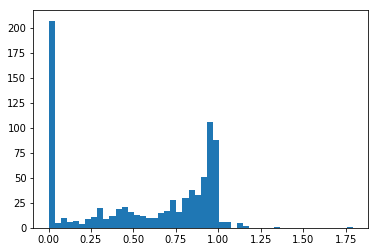

In [17]:
plot = matplotlib.pyplot.hist(joined_df['coverage'], bins=50)

## Display the structures
Display all the structures within some range of PFAM coverage using view_structure and passing a list of PDB IDs

In [21]:
#list(joined_df.index)
#low_coverage_hits = joined_df[(joined_df['coverage'] < 0.75) & (joined_df['coverage'] > 0.25)]
low_coverage_hits = joined_df[joined_df['coverage'] < 0.1]
view_structure(list(low_coverage_hits.index))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Structure', max=219), Output())…

<function mmtfPyspark.structureViewer.view_structure.<locals>.view3d>

In [19]:
spark.stop()